In [ ]:
#!pip install numpy pandas matplotlib seaborn tensorflow

In [66]:
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

In [5]:
#!unzip ./input/cxr_data.zip

mv: rename ./chest_ray/ to ./input/chest_xray: No such file or directory


In [6]:
os.listdir("./chest_xray")

['test', '__MACOSX', 'train', 'val']

# Visualise data

In [10]:
train_dir = "./chest_xray/train"
val_dir = "./chest_xray/test"  # Note swapped val and test round so more in val set 
test_dir = "./chest_xray/val"

train_pneumonia = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))
train_normal = os.listdir(os.path.join(train_dir, 'NORMAL'))
val_pneumonia = os.listdir(os.path.join(val_dir, 'PNEUMONIA'))
val_normal = os.listdir(os.path.join(val_dir, 'NORMAL'))
test_pneumonia = os.listdir(os.path.join(test_dir, 'PNEUMONIA'))
test_normal = os.listdir(os.path.join(test_dir, 'NORMAL'))

print(
    f"""Number of samples:
    TRAIN NORMAL: {len(train_normal)}
    TRAIN PNEUMONIA: {len(train_pneumonia)}
    VAL NORMAL: {len(val_normal)}
    VAL PNEUMONIA: {len(val_pneumonia)}
    TEST NORMAL: {len(test_normal)}
    TEST PNEUMONIA: {len(test_pneumonia)}"""
    )

Number of samples:
    TRAIN NORMAL: 1341
    TRAIN PNEUMONIA: 3875
    VAL NORMAL: 234
    VAL PNEUMONIA: 390
    TEST NORMAL: 8
    TEST PNEUMONIA: 8


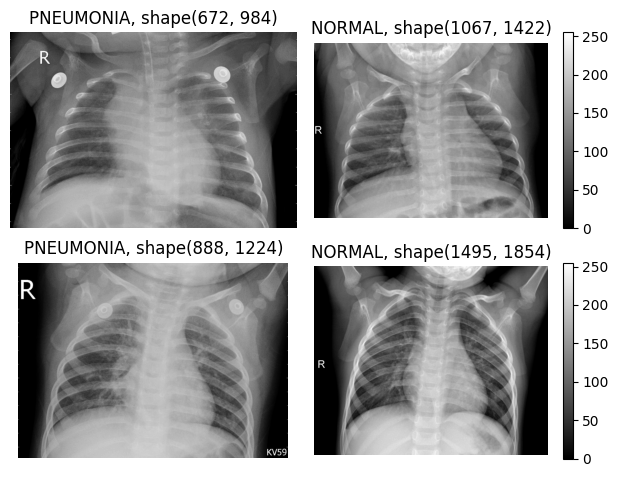

In [33]:
# Visual some images 
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA') 
train_normal_dir = os.path.join(train_dir, 'NORMAL') 

for i in range(1,4,2): 

    # Pneumo cxr 
    img_path_pneumo = os.path.join(train_pneumonia_dir, train_pneumonia[i])
    img_pneumo = plt.imread(img_path_pneumo)
    plt.subplot(2,2,i)
    plt.imshow(img_pneumo, cmap='gray')
    plt.title(f'PNEUMONIA, shape{img_pneumo.shape}')
    plt.axis('off')
    
    # Normal cxr 
    img_path_normal = os.path.join(train_normal_dir, train_normal[i])
    img_normal = plt.imread(img_path_normal)
    plt.subplot(2,2,i+1)
    plt.imshow(img_normal, cmap='gray')
    plt.title(f'NORMAL, shape{img_normal.shape}')
    plt.axis('off')
    plt.colorbar()

plt.tight_layout()

## Process data
Resize, transform, standardise

In [59]:
# Data loader and cache
img_height = 256
img_width = 256

train = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels='inferred', 
  label_mode='binary', 
  class_names=['NORMAL', 'PNEUMONIA'],
  color_mode='grayscale',
  batch_size=8, 
  image_size=(img_height, img_width),
  shuffle=True
).cache()

# Load validation data
validation = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  labels='inferred', 
  label_mode='binary', 
  class_names=['NORMAL', 'PNEUMONIA'],
  color_mode='grayscale',
  batch_size=8, 
  image_size=(img_height, img_width),
  shuffle=False
).cache()

# Load testing data
test = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  labels='inferred', 
  label_mode='binary', 
  class_names=['NORMAL', 'PNEUMONIA'],
  color_mode='grayscale',
  batch_size=1, 
  image_size=(img_height, img_width),
  shuffle=False
).cache()

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


2023-05-31 11:01:52.702116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


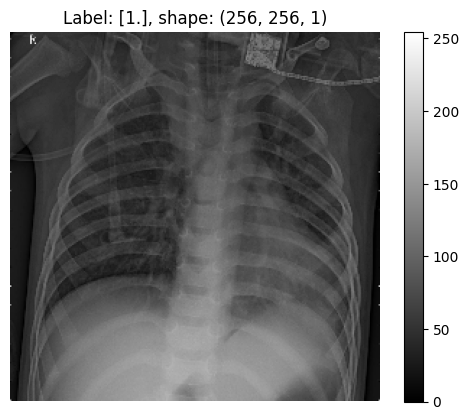

In [60]:
for img, label in train.take(1):
    plt.imshow(img[0], cmap='gray')
    plt.title(f"Label: {label[0]}, shape: {img[0].shape}")
    plt.axis("off")
    plt.colorbar()
    break

2023-05-31 11:01:59.721631: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


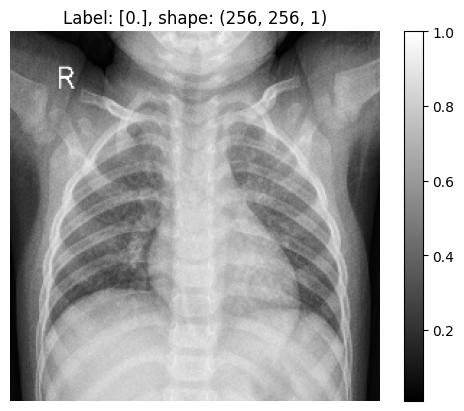

In [61]:
# Normalisation layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train = train.map(lambda x, y: (normalization_layer(x), y))
validation = validation.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))

for img, label in train.take(1):
    plt.imshow(img[0], cmap='gray')
    plt.title(f"Label: {label[0]}, shape: {img[0].shape}")
    plt.axis("off")
    plt.colorbar()
    break

In [ ]:
# Data augmentation
"""image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True)
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))"""

## Train model from scratch

In [ ]:
# clear off GPU
tf.keras.backend.clear_session() # important to clear previous models off the GPU 

# Repeat grayscale image to have 3 channels
def repeat_channels(image):
    return tf.repeat(image, repeats=3, axis=-1)
# Define a lambda layer for the repeating function
repeat_layer = tf.keras.layers.Lambda(repeat_channels)

# Model architecture
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(256, 256, 1))) 
model.add(repeat_layer)
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(256, 256, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='valid'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile
metrics = ['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=metrics)

model.summary()

In [ ]:
# Creating weightings for class imbalances
weight_1 = len(train_normal) / (len(train_normal) + len(train_pneumonia))
weight_0 = len(train_pneumonia) / (len(train_normal) + len(train_pneumonia))
class_weight = {0: weight_0, 1: weight_1}
print(f"Weight for class 0: {weight_0:.2f}")
print(f"Weight for class 1: {weight_1:.2f}")

In [ ]:
history = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

In [ ]:
# Save model
model.save("model_3.h5")

## Transfer learning

In [73]:
## Load pre-trained model

# Clear backened 
tf.keras.backend.clear_session() # important to clear previous models off the GPU 

# Repeat grayscale image to have 3 channels
def repeat_channels(image):
    return tf.repeat(image, repeats=3, axis=-1)
# Define a lambda layer for the repeating function
repeat_layer = tf.keras.layers.Lambda(repeat_channels)

# Create the base pre-trained model
base_net = tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=(256, 256, 3),
    weights='imagenet',
    input_tensor=None,
    pooling='max')
base_net.trainable = False

# Add the layers to a Sequential model
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(256, 256, 1))) 
model.add(repeat_layer)
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [74]:
history_list = {}

def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

Epoch 1/5
652/652 [==============================] - 336s 510ms/step - loss: 0.2717 - accuracy: 0.9220 - val_loss: 0.8165 - val_accuracy: 0.7564
Epoch 2/5
652/652 [==============================] - 380s 582ms/step - loss: 0.1267 - accuracy: 0.9523 - val_loss: 0.5722 - val_accuracy: 0.8253
Epoch 3/5
652/652 [==============================] - 407s 624ms/step - loss: 0.1086 - accuracy: 0.9561 - val_loss: 0.5398 - val_accuracy: 0.8317
Epoch 4/5
652/652 [==============================] - 415s 636ms/step - loss: 0.0928 - accuracy: 0.9666 - val_loss: 0.5087 - val_accuracy: 0.8510
Epoch 5/5
652/652 [==============================] - 417s 639ms/step - loss: 0.0799 - accuracy: 0.9726 - val_loss: 0.6512 - val_accuracy: 0.8173


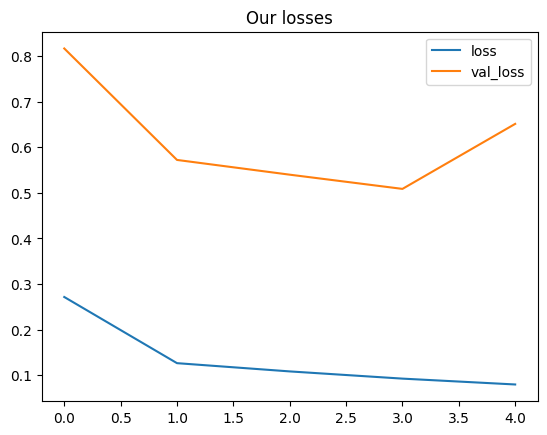

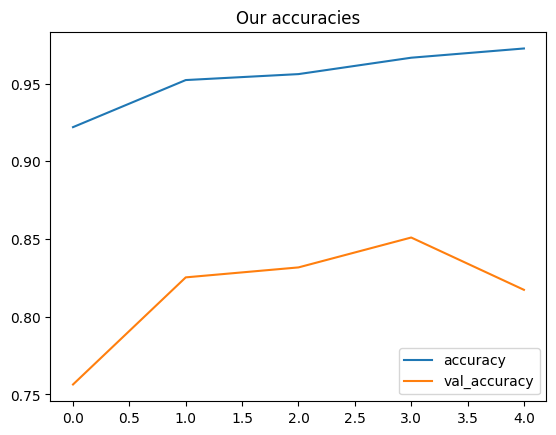

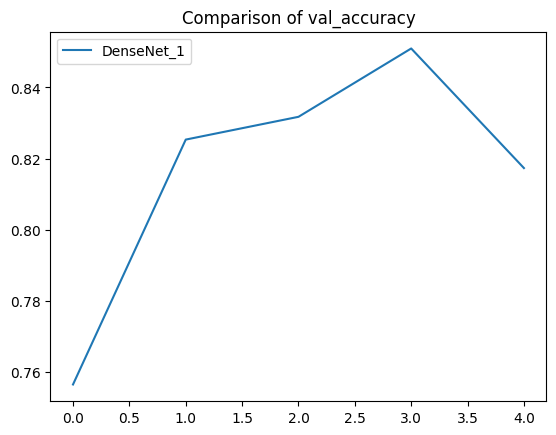

In [75]:
# Fit model
history = model.fit(
    train,
    epochs=5,
    validation_data=validation,
    #callbacks=[WandbCallback],
    #class_weight=class_weight,  # here if you want to change the class weights if imbalanced 
    #steps_per_epoch=100,
    #validation_steps=25,
    )

history_list["DenseNet_1"] = history.history

render_history(history.history)
compare_histories()


In [76]:
# To save model 
model.save("model_1.h5")

# to load: loaded_model = models.load_model("model.h5")


/Users/pauljewell/DSR/Projects/cxr_analyser/cxr/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evauluate model
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")
evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")